C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Размер матрицы: 100x100 | Время CPU: 0.498690 сек | Время GPU: 0.812707 сек | Соответствие: True
Размер матрицы: 200x200 | Время CPU: 3.444296 сек | Время GPU: 0.001994 сек | Соответствие: True
Размер матрицы: 300x300 | Время CPU: 11.638665 сек | Время GPU: 0.019376 сек | Соответствие: True
Размер матрицы: 500x500 | Время CPU: 54.193321 сек | Время GPU: 0.077737 сек | Соответствие: True
Размер матрицы: 600x600 | Время CPU: 91.371278 сек | Время GPU: 0.130474 сек | Соответствие: True
Размер матрицы: 700x700 | Время CPU: 158.830159 сек | Время GPU: 0.155590 сек | Соответствие: True
Размер матрицы: 800x800 | Время CPU: 222.656433 сек | Время GPU: 0.292008 сек | Соответствие: True
Размер матрицы: 1000x1000 | Время CPU: 434.385936 сек | Время GPU: 0.230573 сек | Соответствие: True


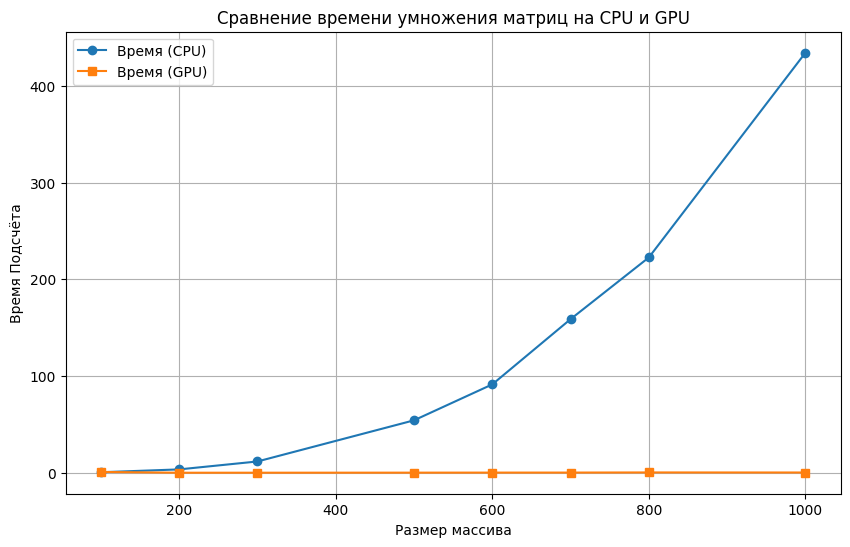

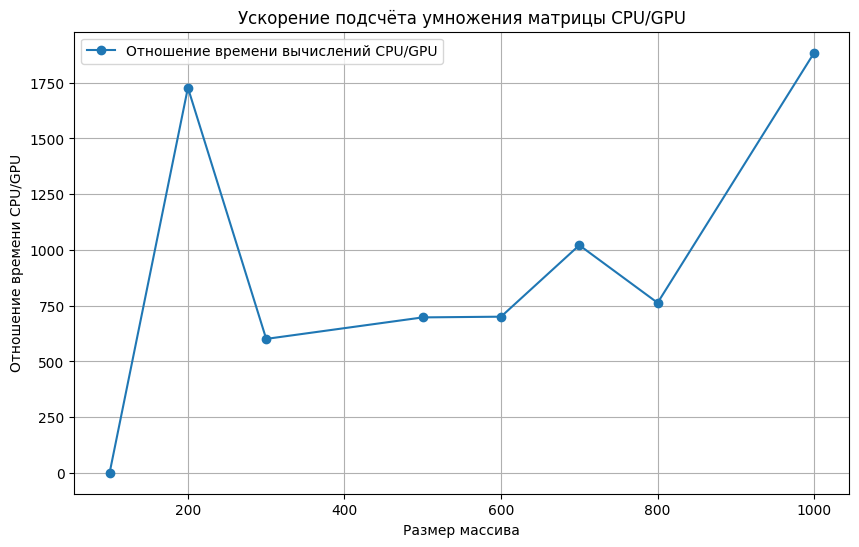

In [1]:
import numpy as np
import time
import torch
from numba import cuda
import matplotlib.pyplot as plt
import math

#перемножение матриц через numpy
def matmul_cpu(A, B):
    C = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            temp_sum = 0.0
            for k in range(A.shape[1]):
                temp_sum += A[i, k] * B[k, j]
            C[i, j] = temp_sum
    return C

#Перемножение матриц на GPU с использованием CUDA
@cuda.jit
def matmul_gpu_kernel(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < B.shape[1]:
        temp_sum = 0
        for k in range(A.shape[1]):
            temp_sum += A[i, k] * B[k, j]
        C[i, j] = temp_sum

def matmul_gpu(A, B):
    #Копируем на GPU
    cuda_A = cuda.to_device(A)
    cuda_B = cuda.to_device(B)
    cuda_C= cuda.device_array((A.shape[0], B.shape[1]), dtype=np.float32)

    #Сетка и блоки
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(A.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(B.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    matmul_gpu_kernel[blocks_per_grid, threads_per_block](cuda_A, cuda_B, cuda_C)
    cuda.synchronize()

    #Копируем обратно на CPU
    C = cuda_C.copy_to_host()
    return C

#размеры матриц
N = [100, 200, 300, 500,600, 700, 800, 1000]
time_cpu = []
time_gpu = []

for i in N:
    A = np.random.rand(i, i).astype(np.float32)
    B = np.random.rand(i, i).astype(np.float32)

    start_time = time.time()
    C_cpu = matmul_cpu(A, B)
    cpu_time = time.time() - start_time

    start_time = time.time()
    C_gpu = matmul_gpu(A, B)
    gpu_time = time.time() - start_time

    flag = np.allclose(C_gpu, C_cpu)
    time_cpu.append(cpu_time)
    time_gpu.append(gpu_time)

    print(f"Размер матрицы: {i}x{i} | Время CPU: {cpu_time:.6f} сек | Время GPU: {gpu_time:.6f} сек | Соответствие: {flag}")

plt.figure(figsize=(10, 6))
plt.plot(N, time_cpu, label='Время (CPU)', marker='o')
plt.plot(N, time_gpu, label='Время (GPU)', marker='s')
plt.xlabel('Размер массива')
plt.ylabel('Время Подсчёта')
plt.title('Сравнение времени умножения матриц на CPU и GPU')
plt.legend()
plt.grid()
plt.show()

#Ускорение
speedup = []
for i in range(len(N)):
    speedup.append(time_cpu[i]/time_gpu[i])
plt.figure(figsize=(10, 6))
plt.plot(N, speedup, label='Отношение времени вычислений CPU/GPU', marker='o')
plt.xlabel('Размер массива')
plt.ylabel('Отношение времени CPU/GPU')
plt.title('Ускорение подсчёта умножения матрицы CPU/GPU')
plt.legend()
plt.grid()
plt.show()